In [ ]:
# Mount google drive

import json
import os
from google.colab import drive

drive.mount('/content/drive/')
os.chdir("/content/drive/MyDrive/dfdcDataset/dfdc_train_part_45")



In [ ]:
# Filter data into real and fake

f = open('metadata.json', "r")

metadata = json.loads(f.read())
metadata = metadata
fakes = []
reals = []
for each in metadata.keys():
  if metadata[each]["label"] == "FAKE":
    fakes.append(each)
  else:
    reals.append(each)
fakes = fakes[:200]
reals = reals[:200]
print(len(fakes), len(reals))

In [ ]:
import cv2
import tensorflow

In [ ]:
def extract_frames(video_path, frame_rate):
    video = cv2.VideoCapture(video_path)
    fps = video.get(cv2.CAP_PROP_FPS)
    framesInterval = int(fps * frame_rate)
    count = 0
    frames = []
    while video.isOpened():
        ret, frame = video.read()
        if not ret:
            break
        if count % framesInterval == 0:
            frames.append(frame)
        count += 1
    video.release()
    return frames

realFrames = {}
fakeFrames = {}
for each in reals:
  realFrames[each] = extract_frames(each, 7)


for each in fakes:
  fakeFrames[each] = extract_frames(each, 7)


In [ ]:
import numpy as np

def frames_to_dataset(frames_dict, label):
    X = []
    y = []
    for video_path, frames in frames_dict.items():
        for frame in frames:
            frame_resized = cv2.resize(frame, (299, 299))
            X.append(frame_resized)
            y.append(label)
    return np.array(X), np.array(y)

X_real, y_real = frames_to_dataset(realFrames, 0)
X_fake, y_fake = frames_to_dataset(fakeFrames, 1)

X_train = np.concatenate((X_real, X_fake), axis=0)
y_train = np.concatenate((y_real, y_fake), axis=0)

X_train = X_train.astype('float32') / 255.0


In [6]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train, random_state=0)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [7]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers


base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
for layer in base_model.layers:
  layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("done")

219055592/219055592 [==============================] - 8s 0us/step
done


In [ ]:
# print(X_val,"DFSF")
# print(y_val, "fdasf")

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

validation_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=20
)


validation_generator = validation_datagen.flow(X_val, y_val, batch_size=32)


history = model.fit(
    train_generator,
    steps_per_epoch = max(1, len(X_train) // 20),
    epochs=10,
    validation_data= validation_generator,
    validation_steps = max(1, len(X_val) // 20)
)


Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 0.6850 - accuracy: 0.7250

32/32 [==============================] - 414s 13s/step - loss: 0.6850 - accuracy: 0.7250 - val_loss: 0.3954 - val_accuracy: 0.8375
Epoch 2/10
32/32 [==============================] - 310s 10s/step - loss: 0.5098 - accuracy: 0.7531
Epoch 3/10
32/32 [==============================] - 318s 10s/step - loss: 0.5196 - accuracy: 0.7563
Epoch 4/10
32/32 [==============================] - 311s 10s/step - loss: 0.4399 - accuracy: 0.7984
Epoch 5/10
32/32 [==============================] - 315s 10s/step - loss: 0.4224 - accuracy: 0.7953
Epoch 6/10
32/32 [==============================] - 310s 10s/step - loss: 0.4402 - accuracy: 0.7984
Epoch 7/10
32/32 [==============================] - 317s 10s/step - loss: 0.4137 - accuracy: 0.8062
Epoch 8/10
32/32 [==============================] - 314s 10s/step - loss: 0.4136 - accuracy: 0.8094
Epoch 9/10
32/32 [==============================] - 311s 10s/step - loss: 0.3963 - accuracy: 0.8031
Epoch 10/10
32/32 [==============================] - 317s 10s/step - 

In [10]:

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_val, y_val, batch_size=20)  # Adjust batch size if necessary
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

predictions = model.predict(X_val, batch_size=20)
predictions = [1 if x > 0.5 else 0 for x in predictions.ravel()]
model.save('inceptionResNet.h5')


8/8 [==============================] - 74s 9s/step - loss: 0.3996 - accuracy: 0.8375
Test Loss: 0.3996080756187439
Test Accuracy: 0.8374999761581421
8/8 [==============================] - 81s 10s/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:

# from google.colab.patches import cv2_imshow

# def visualize_predictions(frames, predictions):
#     for i, frame in enumerate(frames):
#         prediction = predictions[i]
#         label = "FAKE" if prediction > 0.5 else "REAL"
#         confidence = f"{(prediction if label == 'FAKE' else 1 - prediction) * 100:.2f}%"


#         vis_frame = frame.copy()
#         cv2.putText(vis_frame, f"{label}", (10, 30),
#                     cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0) if label == "REAL" else (0, 0, 255), 2)


#         cv2_imshow(vis_frame)
#         break

# predictions = model.predict(X_val, batch_size=32).ravel()
# X_test_vis = (X_val * 255).astype('uint8')
# visualize_predictions(X_test_vis, predictions)

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

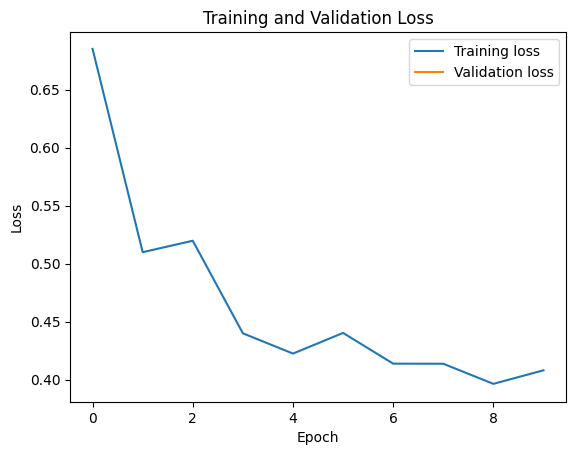

In [13]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

5/5 [==============================] - 84s 15s/step


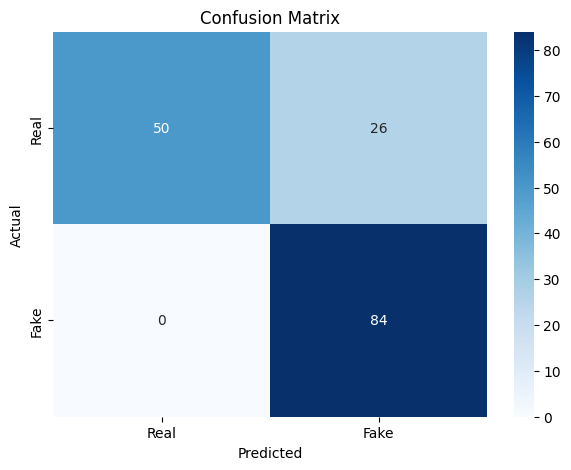

In [14]:

y_pred = (model.predict(X_val) > 0.5).astype("int32")

cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
import lightgbm as lgb

# Load models
model_1 = lgb.Booster(model_file='path/to/your_first_model.txt')
model_2 = lgb.Booster(model_file='path/to/your_second_model.txt')

In [15]:
# # model.save("incresnetFinal.h5")
# import numpy as np

# def frames_to_dataset(frames_dict, label):
#     X = []
#     y = []
#     for video_path, frames in frames_dict.items():
#         for frame in frames:
#             frame_resized = cv2.resize(frame, (299, 299))
#             X.append(frame_resized)
#             y.append(label)
#     return np.array(X), np.array(y)

# X_real, y_real = frames_to_dataset(realFrames, 0)
# X_fake, y_fake = frames_to_dataset(fakeFrames, 1)

# X_train = np.concatenate((X_real, X_fake), axis=0)
# y_train = np.concatenate((y_real, y_fake), axis=0)

# X_train = X_train.astype('float32') / 255.0

In [16]:
# from sklearn.utils import shuffle

# X_train, y_train = shuffle(X_train, y_train, random_state=0)

# from sklearn.model_selection import train_test_split

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [17]:
# import tensorflow as tf
# from tensorflow.keras.applications import DenseNet121
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam

# Dense_base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# x = Dense_base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.5)(x)
# predictions = Dense(1, activation='sigmoid')(x)
# model2 = Model(inputs=Dense_base_model.input, outputs=predictions)
# model2.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


In [18]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# train_datagen2 = ImageDataGenerator(
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True)

# validation_datagen2 = ImageDataGenerator()

# train_generator2 = train_datagen2.flow(
#     X_train, y_train,
#     batch_size=20
# )


# validation_generator2 = validation_datagen2.flow(X_val, y_val, batch_size=32)


# history = model2.fit(
#     train_generator2,
#     steps_per_epoch = max(1, len(X_train) // 20),
#     epochs=10,
#     validation_data=validation_generator2,
#     validation_steps = max(1, len(X_val) // 20)
# )


In [19]:
# print("done")

In [20]:
# import numpy as np
# from sklearn.metrics import confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Predict classes with the model
# validation_generator2.reset()  # Reset the generator to ensure alignment
# predictions = model2.predict(validation_generator2, steps=np.ceil(len(X_val)/32))
# predicted_classes = (predictions > 0.5).astype(int)

# # Retrieve true labels
# true_classes = y_val


In [21]:
# cm = confusion_matrix(true_classes, predicted_classes)

# # Plot using seaborn
# plt.figure(figsize=(5,5))
# sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues')
# plt.ylabel('Actual label')
# plt.xlabel('Predicted label')
# plt.title('Confusion Matrix', size = 15)
# plt.show()

In [22]:
# plt.figure(figsize=(8, 4))
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(loc='upper right')
# plt.show()

In [23]:
# def extract_features(model, generator, steps):
#     features = model.predict(generator, steps=steps)
#     return features

# train_features_DenseNet121 = extract_features(model2, train_generator2, steps=np.ceil(len(X_train)/20))
# val_features_DenseNet121 = extract_features(model2, validation_generator2, steps=np.ceil(len(X_val)/32))

# train_features_InceptionResNetV2 = extract_features(model, train_generator, steps=np.ceil(len(X_train)/20))
# val_features_InceptionResNetV2 = extract_features(model, validation_generator, steps=np.ceil(len(X_val)/32))


In [24]:
# train_features_combined = np.concatenate([train_features_DenseNet121, train_features_InceptionResNetV2], axis=1)
# val_features_combined = np.concatenate([val_features_DenseNet121, val_features_InceptionResNetV2], axis=1)

In [25]:
# import lightgbm as lgb


# d_train = lgb.Dataset(train_features_combined, label=y_train)
# d_valid = lgb.Dataset(val_features_combined, label=y_val)


# params = {
#     'objective': 'binary',
#     'metric': 'binary_logloss',
#     'verbose': -1
# }


# model = lgb.train(
#     params,
#     d_train,
#     valid_sets=[d_valid],
#     num_boost_round=100
# )


In [26]:
# y_pred = model3.predict(val_features_combined, num_iteration=model.best_iteration)


In [27]:
# from sklearn.metrics import accuracy_score, confusion_matrix

# # Apply threshold to get binary output
# y_pred_binary = (y_pred > 0.5).astype(int)

# # Calculate accuracy
# accuracy = accuracy_score(y_val, y_pred_binary)
# print(f'Accuracy: {accuracy}')

# # Confusion matrix
# cm = confusion_matrix(y_val, y_pred_binary)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()
